In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
df = pd.read_csv('/content/Nat_Gas.csv')
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [45]:
df['Dates']=pd.to_datetime(df['Dates'])

/tmp/ipython-input-45-2958409106.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates']=pd.to_datetime(df['Dates'])


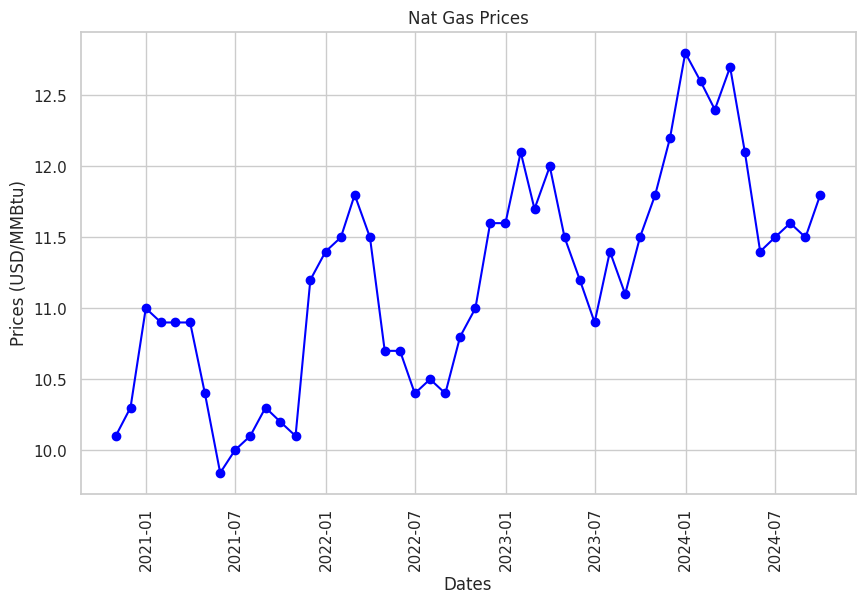

In [46]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
plt.plot(df['Dates'],df['Prices'],marker = 'o', color = 'blue')
plt.title('Nat Gas Prices')
plt.xlabel('Dates')
plt.ylabel('Prices (USD/MMBtu)')
plt.xticks(rotation=90)
plt.show()

## Inferences
1. we can observe an increased trend of prices through the years.
2. A seasonal pattern can be observed where the winter months have higher prices than summer ones.

## SARIMAX model to capture seasonality and trend

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [48]:
model = SARIMAX(df['Prices'],order=(1,1,1),seasonal_order=(1,1,1,12),enforce_invertibility=False,enforce_stationarity=False)

results = model.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


## Forecasting Price values for the next 12 months

In [50]:
df = df.set_index('Dates')

In [51]:
forecast_steps = 12
forecast_obj = results.get_forecast(steps=forecast_steps)

# Monthly forecasted values
forecast_monthly = forecast_obj.predicted_mean

# Create future month-end dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')
forecast_monthly.index = future_dates

/tmp/ipython-input-51-1703245206.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='M')


In [53]:
forecast_monthly.head(10)

,predicted_mean
2024-10-31,12.125720
2024-11-30,12.588710
2024-12-31,12.934791
2025-01-31,13.039961
2025-02-28,12.761521
2025-03-31,13.052296
2025-04-30,12.494460
2025-05-31,11.979335
2025-06-30,11.898212
2025-07-31,12.174308


## Interpolating to estimate daily values

In [55]:
full_monthly = pd.concat([df['Prices'], forecast_monthly])

# Create daily date range from start to end (1 year beyond last month)
daily_index = pd.date_range(start=full_monthly.index.min(), end=full_monthly.index.max() + pd.Timedelta(days=30), freq='D')

# Reindex to daily frequency
df_daily = full_monthly.reindex(daily_index)

# Interpolating missing daily values using time-based interpolation
df_daily = df_daily.interpolate(method='time')

In [56]:
df_daily.head()

,0
2020-10-31,10.100000
2020-11-01,10.106667
2020-11-02,10.113333
2020-11-03,10.120000
2020-11-04,10.126667


## Trend of daily purchasing price of NG

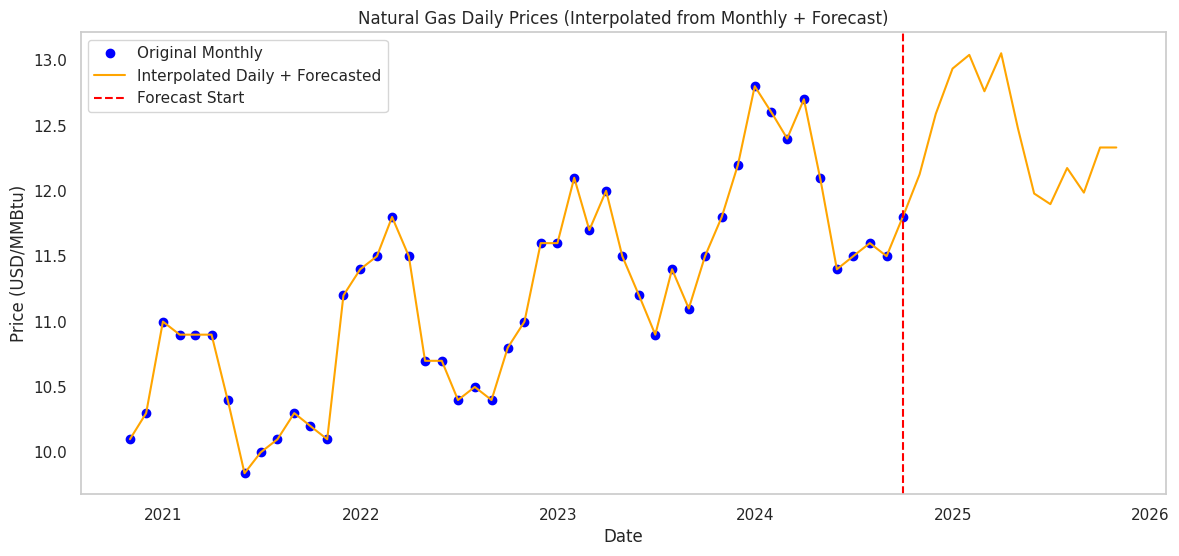

In [58]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Prices'], 'o', label='Original Monthly', color='blue')
plt.plot(df_daily.index, df_daily, '-', label='Interpolated Daily + Forecasted', color='orange')
plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
plt.title("Natural Gas Daily Prices (Interpolated from Monthly + Forecast)")
plt.xlabel("Date")
plt.ylabel("Price (USD/MMBtu)")
plt.legend()
plt.grid()
plt.show()

## Function to take input from user and return the price estimate

In [59]:
def get_price_on_date(date_str):
    try:
        target_date = pd.to_datetime(date_str)
    except:
        return f"Invalid date format. Use YYYY-MM-DD."

    if target_date < df_daily.index.min() or target_date > df_daily.index.max():
        return f"Date out of range. Choose between {df_daily.index.min().date()} and {df_daily.index.max().date()}"

    return round(df_daily.loc[target_date], 3)

In [63]:
date_inp = input("Enter the date (YYYY-MM-DD): ")
print("Price estimate of NG = ",get_price_on_date(date_inp))

Enter the date (YYYY-MM-DD): 2024-07-24
Price estimate of NG =  11.577
